In [12]:

token = '0269d7992397d34fa4514c08edc3e3dbb557a8616d1d3af782f6759c3472f7821942dce6da4b4162bf40a24506f16c21bc384a85fcb8b40e9faa185fed6a64ca'

from qiskit import QuantumCircuit
qc = QuantumCircuit(2)  # Create a 2-qubit quantum circuit
qc.h(0)  # Apply Hadamard gate to the first qubit
qc.cx(0, 1)  # Apply CNOT gate between qubit 0 and 1(operation on 1th index based on 0th index)
# qc.measure_all()  # Measure all qubits

In [13]:
# print(qc.draw())  # Draw the circuit
qc.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

In [14]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel="ibm_quantum", token = token) # ibm_cloud 
# QiskitRuntimeService.save_account(channel='ibm_quantum',token = token)

backend = service.least_busy(simulator=False, operational=True)

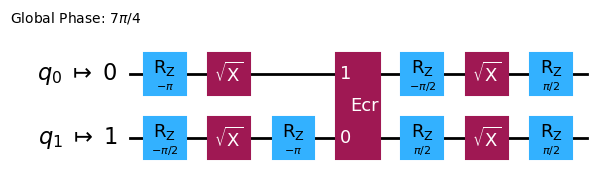

In [15]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
 
isa_circuit.draw("mpl", idle_wires=False)

In [16]:
# Construct the Estimator instance.
from qiskit_ibm_runtime import EstimatorV2 as Estimator

estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

from qiskit.quantum_info import SparsePauliOp
# Set up six different observables.
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]
 
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])
 
# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cx1mgf9tpsjg0086f6z0


In [17]:
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()
job_result


PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(6,), dtype=float64>), stds=np.ndarray(<shape=(6,), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(6,), dtype=float64>), shape=(6,)), metadata={'shots': 5024, 'target_precision': 0.01414213562373095, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2})

In [18]:
# This is the result from our single pub, which had six observables,
# so contains information on all six.
pub_result = job.result()[0]

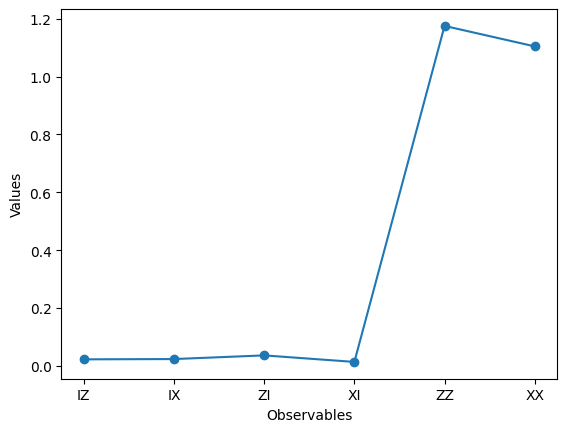

In [19]:
# Plot the result
 
from matplotlib import pyplot as plt
 
values = pub_result.data.evs
 
errors = pub_result.data.stds
 
# plotting graph
plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()